In [2]:
# Let's start by creating a sample dataset.

import json
from dotenv import load_dotenv

# Load api keys from .env file
load_dotenv(override=True) 

"""
You can also create your own jsonl file where each line is in this format:
{
    "query": {
        "id": "q1",
        "query": "What is the capital of France?"
    },
    "documents": [
        {"id": "d1", "content": "Paris is the capital of France.", "score": 0.9},
        {"id": "d2", "content": "Rome is the capital of Italy.", "score": 0.8},
        ...
    ]
}

An example of such a file can be found at `./data/legalquad.jsonl`.
The scores are optional, if not provided, the score of the ith document will be set to 1 / (i + 1).
"""

# Here's an example of how to create such a dataset:
with open("./data/my_sample_dataset_annotated.jsonl", "w") as f:
    f.write(json.dumps(
        {
            "query": {
                "id": "q1",
                "query": "What is the capital of France?"
            },
            "documents": [
                # Oh no, we scored it high, but this document is not relevant to the query!
                {"id": "d1", "content": "Paris has a capital letter. France also has a capital letter.", "score": 0.9},
                # This is what we actually want
                {"id": "d2", "content": "Paris is the capital of France.", "score": 0.7},
                # This is definitely not relevant to the query
                {"id": "d3", "content": "Rome is the capital of Italy.", "score": 0.2},
            ]
        }
    ))

with open("./data/my_sample_dataset.jsonl", "w") as f:
    f.write(json.dumps(
        {
            "query": {
                "id": "q1",
                "query": "What is the capital of France?"
            },
            "documents": [
                {"id": "d1", "content": "Paris has a capital letter. France also has a capital letter."},
                {"id": "d2", "content": "Paris is the capital of France."},
                {"id": "d3", "content": "Rome is the capital of Italy."},
            ]
        }
    ))


In [3]:
# At first, we need to Ensemble annotate the dataset.
# We can do this by running the following code:

from zbench.annotation import EnsembleELOAnnotator

# We'll initialize an ELO annotator that will read from our example dataset, and output an annotated dataset.
SOURCE_DATASET_PATH = "./data/my_sample_dataset.jsonl"
SOURCE_ANNOTATED_DATASET_PATH = "./data/my_sample_dataset_annotated.jsonl"
ANNOTATED_DATASET_PATH = "./data/my_sample_dataset_ensemble_annotated.jsonl"
annotator = EnsembleELOAnnotator(SOURCE_DATASET_PATH, ANNOTATED_DATASET_PATH)

# Now, we'll run the ELO annotator. It will write to the jsonl file we specified in the constructor.
await annotator.elo_annotate()

Step 1: Loading dataset
Loaded 1 queries from data/annotation/my_sample_dataset/dataset.jsonl
Step 2: Creating pairs for AI scoring


Creating pairs: 100%|██████████| 1/1 [00:00<00:00, 2799.94it/s]


Created 12 pairs and saved to data/annotation/my_sample_dataset/pairs.json
Step 3: Scoring pairs


Scoring Pairs: 100%|██████████| 12/12 [00:24<00:00,  2.04s/it]

Scored 12 pairs and saved to data/annotation/my_sample_dataset/sai_scores.json
Step 4: Composing annotated dataset
Created 1 annotated lines
Saved annotated dataset to ./data/my_sample_dataset_ensemble_annotated.jsonl

🎉 Annotation completed successfully!
Final outputs:
Annotated dataset: ./data/my_sample_dataset_ensemble_annotated.jsonl


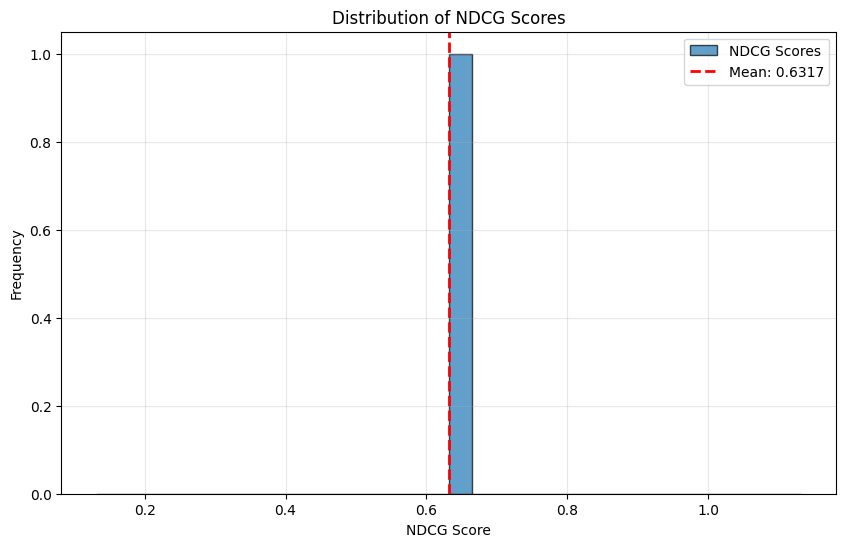

[np.float64(0.6316740659321393)]
[0.6666666666666666]
[0.0]


In [4]:
# Finally, we can run three benchmarks:

from zbench.benchmark import benchmark_ndcg, benchmark_accuracy, recall_at_k
from zbench.rerankers import EnsembleReranker

print(benchmark_ndcg(SOURCE_ANNOTATED_DATASET_PATH, ANNOTATED_DATASET_PATH, visualize=True)) # you can visualise the ndcg score distribution
print(benchmark_accuracy(SOURCE_ANNOTATED_DATASET_PATH, ANNOTATED_DATASET_PATH))
print(recall_at_k(SOURCE_ANNOTATED_DATASET_PATH, ANNOTATED_DATASET_PATH, 1, k_gt=1))

# As for recall at k, we also introduce a parameter k_gt, which is the number of ground truth documents to consider since the annotation does not separate the ground truth, just the order. For the best results, you can tune k_gt depending on the annotations score distritribution.


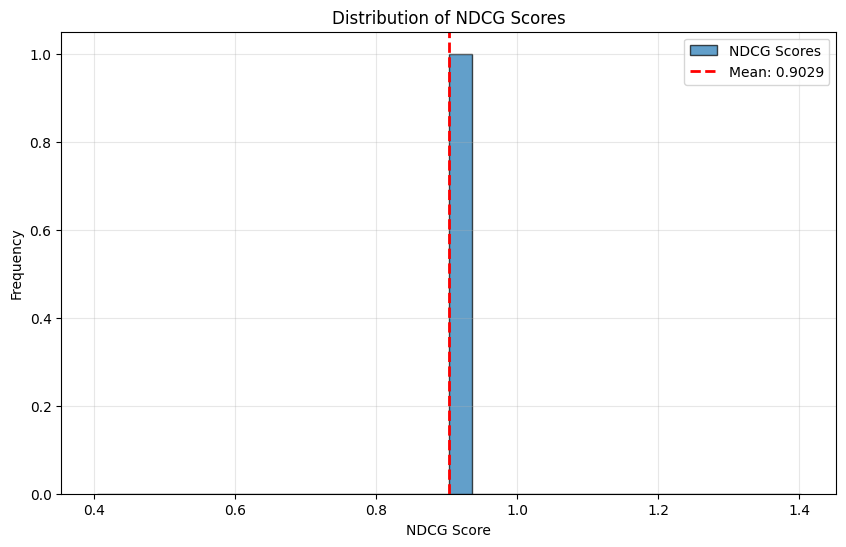

[np.float64(0.9028944580267518)]
[0.6666666666666666]
[0.0]


In [8]:
# You can also use built-in zerank reranker.

from zbench.rerankers import Zerank

zerank = Zerank("zerank-1")
ZERANK_ANNOTATED_DATASET_PATH = "./data/my_sample_dataset_zerank_annotated.jsonl"
await zerank.annotate(SOURCE_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH)

# Now, you can run the benchmarks:
print(benchmark_ndcg(SOURCE_ANNOTATED_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH, visualize=True)) # you can visualise the ndcg score distribution
print(benchmark_accuracy(SOURCE_ANNOTATED_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH))
print(recall_at_k(SOURCE_ANNOTATED_DATASET_PATH, ZERANK_ANNOTATED_DATASET_PATH, 1, k_gt=1))


In [ ]:
# For (q1, d2), show all of the Ensemble ELO annotations for that document.

from zbench.common_types import DatasetPairScoredPairs
from zbench.utils import load_json

# Load the AI scores
ai_scores: DatasetPairScoredPairs = DatasetPairScoredPairs.model_validate(load_json("data/annotation/my_sample_dataset/ai_scores.json"))

# Find pairs involving d2 for query q1
target_query_id = "q1"
target_document_id = "d2"

print(f"QUERY: ({target_query_id}) What is the capital of France?")
print(f"\nDOCUMENT: ({target_document_id}) Paris is the capital of France.")
print(f"\nANNOTATIONS:")

for scored_pair in ai_scores.scored_pairs:
    pair = scored_pair.pair
    if pair.query_id == target_query_id:
        # Check if d2 is either document_a or document_b
        if pair.document_a.document_id == target_document_id:
            # d2 is document_a, so competing document is document_b
            competing_doc = pair.document_b
        elif pair.document_b.document_id == target_document_id:
            # d2 is document_b, so competing document is document_a
            competing_doc = pair.document_a
        else:
            continue  # This pair doesn't involve d2
        
        print(f"\n- Competing Document: ({competing_doc.document_id}) {competing_doc.content}")
        print("OpenAI Thoughts:")
        for line in scored_pair.openai_score.thought.split('\n'):
            if line.strip():
                print(f"    > {line.strip()}")
        print("Gemini Thoughts:")
        for line in scored_pair.gemini_score.thought.split('\n'):
            if line.strip():
                print(f"    > {line.strip()}")
        print("Claude Thoughts:")
        for line in scored_pair.anthropic_score.thought.split('\n'):
            if line.strip():
                print(f"    > {line.strip()}")


FileNotFoundError: [Errno 2] No such file or directory: 'data/annotation/my_sample_dataset/sai_scores.json'